<a href="https://colab.research.google.com/github/DianaAkolzina/scientific_paper_classifier/blob/scibert/Model_fighting_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.cloud import bigquery
import logging
from torch.utils.tensorboard import SummaryWriter
from transformers.trainer_utils import EvalPrediction
from transformers import EarlyStoppingCallback
from google.colab import auth
import torch.nn as nn

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

auth.authenticate_user()
project_id = "scientific-paper-classifier"
client = bigquery.Client(project=project_id)

query = """
SELECT Processed_Text,  Label
FROM data_train.processed_text_10000
"""
df = client.query(query).to_dataframe()
logging.info(f"Retrieved {len(df)} rows from BigQuery")

In [5]:
# Data Preprocessing and Balancing
text_column = 'Processed_Text'
label_column = 'Label'

combined_df = df
combined_df.reset_index(drop=True, inplace=True)
combined_df['Label'] = combined_df['Label'].astype('category')
logging.info(f"Preprocessed data: {combined_df.shape}")

label_counts = combined_df['Label'].value_counts()
min_category_size = label_counts.min()
balanced_df = pd.concat([
    combined_df[combined_df['Label'] == label].sample(n=min_category_size, random_state=42)
    for label in combined_df['Label'].cat.categories
])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
logging.info(f"Balanced dataset: {balanced_df.shape}")

X = balanced_df['Processed_Text']
y = balanced_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logging.info(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

In [6]:
# Other constants
max_length = 256
batch_size = 32
epochs = 15
learning_rate = 2e-5

# Tokenization and Dataset Creation
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.tolist())

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [7]:
# Model Initialization with Dropout
model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(balanced_df['Label'].unique()))
model.to(device)

# Fine-Tuning Parameters
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)  # L2 regularization
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)
criterion = nn.CrossEntropyLoss()
clip_grad_norm = 1.0

# Training Loop with Dropout
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        total_loss += loss.item()
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Validating'):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}

            outputs = model(**inputs)
            test_loss += criterion(outputs.logits, inputs['labels']).item()

    test_avg_loss = test_loss / len(test_dataloader)
    test_losses.append(test_avg_loss)

    if test_avg_loss < best_test_loss:
        best_test_loss = test_avg_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {test_avg_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validating: 100%|██████████| 29/29 [00:07<00:00,  4.03it/s]


Epoch 1/15, Train Loss: 0.0930, Test Loss: 0.0284


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.82it/s]


Epoch 2/15, Train Loss: 0.0199, Test Loss: 0.0020


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


Epoch 3/15, Train Loss: 0.0010, Test Loss: 0.0073


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


Epoch 4/15, Train Loss: 0.0012, Test Loss: 0.0023


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


Epoch 5/15, Train Loss: 0.0025, Test Loss: 0.0014


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 6/15, Train Loss: 0.0001, Test Loss: 0.0014


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 7/15, Train Loss: 0.0000, Test Loss: 0.0015


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 8/15, Train Loss: 0.0000, Test Loss: 0.0012


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 9/15, Train Loss: 0.0000, Test Loss: 0.0018


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 10/15, Train Loss: 0.0000, Test Loss: 0.0015


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


Epoch 11/15, Train Loss: 0.0000, Test Loss: 0.0013


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


Epoch 12/15, Train Loss: 0.0000, Test Loss: 0.0011


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 13/15, Train Loss: 0.0000, Test Loss: 0.0050


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 14/15, Train Loss: 0.0000, Test Loss: 0.0028


Validating: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


Epoch 15/15, Train Loss: 0.0000, Test Loss: 0.0028


<All keys matched successfully>

In [8]:
# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluating'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

Evaluating: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]


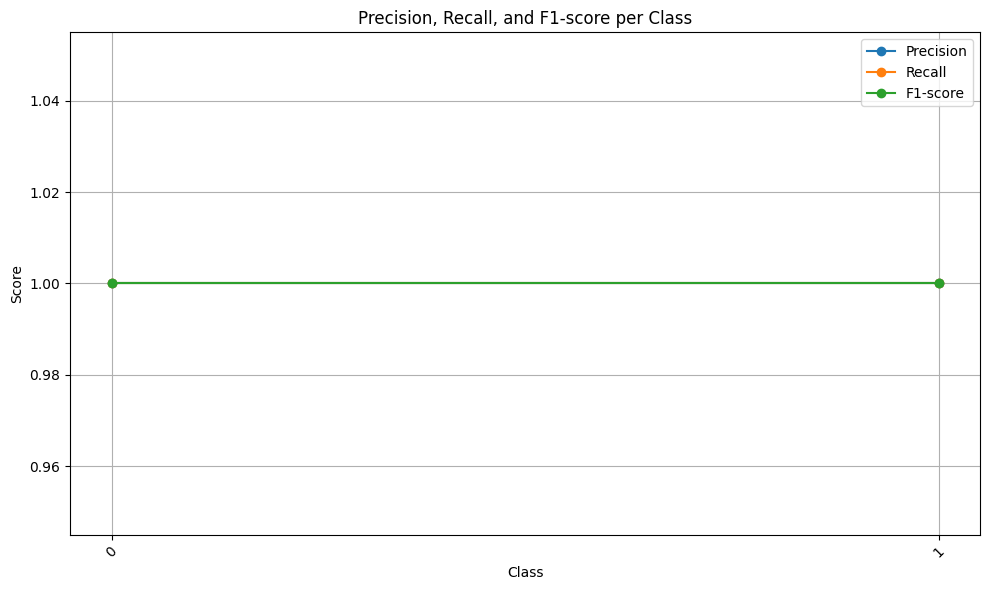

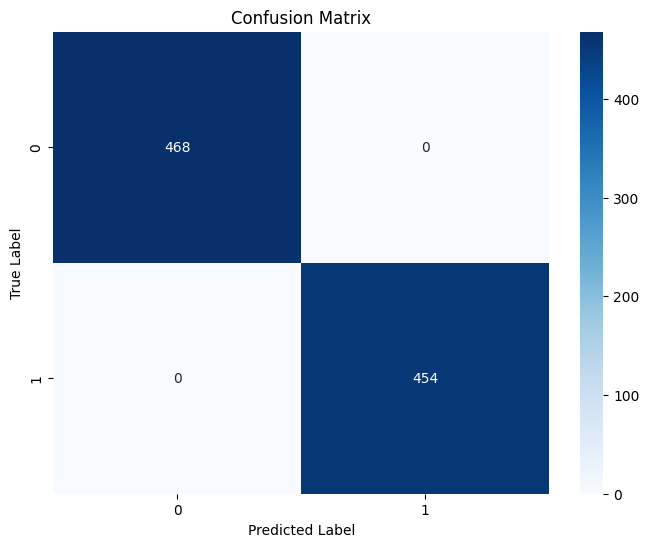

Overall Accuracy: 1.0000


In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting Precision, Recall, and F1-score for each class
def plot_metrics_per_class(metrics_dict, title):
    plt.figure(figsize=(10, 6))
    for metric, values in metrics_dict.items():
        plt.plot(class_names, values, marker='o', label=metric)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate precision, recall, and F1-score
class_names = [str(label) for label in balanced_df['Label'].unique().tolist()]
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)
precision = [report[label]['precision'] for label in class_names]
recall = [report[label]['recall'] for label in class_names]
f1 = [report[label]['f1-score'] for label in class_names]

# Overall Accuracy
accuracy = accuracy_score(true_labels, predictions)

# Plot Precision, Recall, and F1-score for each class
metrics_dict = {'Precision': precision, 'Recall': recall, 'F1-score': f1}
plot_metrics_per_class(metrics_dict, 'Precision, Recall, and F1-score per Class')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Overall Metrics
print(f'Overall Accuracy: {accuracy:.4f}')

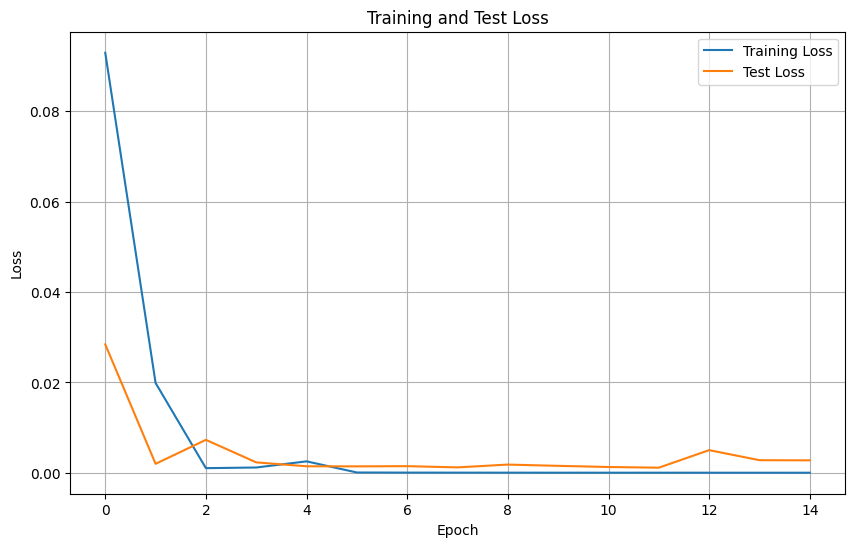

In [11]:
import matplotlib.pyplot as plt

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Save and Load Model
model_path = 'scibert_fine_tuned_model_n.pth'
torch.save(model.state_dict(), model_path)
logging.info(f"Fine-tuned model saved to: {model_path}")

# Load the Fine-Tuned Model
loaded_model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(balanced_df['Label'].unique()))
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)
logging.info("Fine-tuned model loaded successfully")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/MyDrive/model/model.safetensors')

Mounted at /content/drive


In [15]:
!gsutil cp /content/drive/MyDrive/model/model.safetensors gs://scientific_paper_classifier-bucket/models/scibert_model_n.h5

Omitting directory "file:///content/drive/MyDrive/model/model.safetensors". (Did you mean to do cp -r?)
CommandException: No URLs matched. Do the files you're operating on exist?


In [16]:
from google.colab import files
files.download('/content/scibert_fine_tuned_model_nevena2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>